# Data rejection, resp. trig -> SNR/LW gain?

In [1]:
# %% init
from IPython import get_ipython
import matplotlib.pylab as plt
import matplotlib.colors as coco
from matplotlib import dates
from datetime import datetime
import mrs.reco as reco
import mrs.log as log
import mrs.paths as default_paths
import numpy as np
import pickle
get_ipython().magic("clear")
plt.close("all")

get_ipython().magic("matplotlib notebook")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.max_open_warning'] = 1000
plt.rcParams["figure.figsize"] = [8, 6]
log.setLevel(log.DEBUG)

import os
os.chdir("/home/tangir/crmbm/python/shrimp")


rdb = reco.data_db("/home/tangir/crmbm/data_reco/sc_db.pkl")


(DEBUG) Loaded backend nbAgg version unknown.
(INFO)  data_db.__init__: storage file [/home/tangir/crmbm/data_reco/sc_db.pkl] already exists!


(INFO)  data_db.get_datasets: getting datasets/pipelines using check function [<function select_func_twix at 0x7f51984b8790>]...
(DEBUG) data_db.read: reading db file [/home/tangir/crmbm/data_reco/sc_db.pkl]...
(DEBUG) data_db.read: reading db file [/home/tangir/crmbm/data_reco/sc_db.pkl]...


[#] [Patient name]        [Dataset name]
0   314_YT_P2_MOELLE      #0 sLASER 20/1 NA=128
1   313_FT_P2_MOELLE      #1 sLASER 20/1
2   319_FC_P2_MOELLE      #1 sLASER 10/2 NA=64 trig
3   336_NB_P2_MOELLE      #0 sLASER 20/1 NA=128 trig
4   336_NB_P2_MOELLE      #1 sLASER 20/1 NA=64 notrig
5   336_NB_P2_MOELLE      #2 sLASER 10/2 NA=64 notrig
6   336_NB_P2_MOELLE      #3 sLASER 5/1 NA=64 notrig
7   311_SL_P2_MOELLE      #0 sLASER 20/1 NA=128 trig
8   311_SL_P2_MOELLE      #0 sLASER 20/1 NA=128 notrig
9   304_KA_P2_MOELLE      #1 1st try (30-40Hz water LW)
10  304_KA_P2_MOELLE      #3 2nd try (25Hz water LW)
11  355_ST_P1_MOELLE      #1 sLASER TE=52ms
12  349_AP_P1_MOELLE      #1 sLASER 10:2 (REF with OVS)
13  300_PM_P2_MOELLE      #1 sLASER 20:1 (REF with OVS)
14  338_RO_P1_MOELLE      #1 sLASER 20:1 WS (TWIX)
15  329_PI_P1_MOELLE      #1 sLASER 20:1 (TWIX)
16  328_AF_P1_MOELLE      #1 sLASER 20:1 (TWIX)
17  319_FC_P1_MOELLE      #1 sLASER 20:1 (TWIX)
18  319_FC_P1_MOELLE      #1 sLASER 

<IPython.core.display.Javascript object>


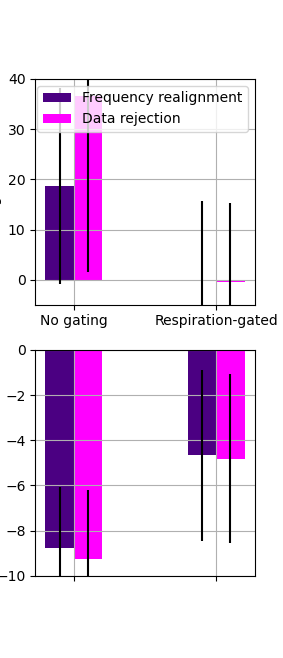

In [3]:
# %% evaluate average SNR and LW gain when processing TWIX full way compared to before applying data-rej and realign
snr_ts = 10

def select_func_twix(d, p):
    kl = list(p._analyze_results_dict[d.display_label]["snr"].keys())
    last_job = kl[-1]
    final_snr = p._analyze_results_dict[d.display_label]["snr"][last_job]

    r = (not d.is_dicom and
         "IR" not in d.display_label and
         final_snr > snr_ts)
    return(r)

data_twix_list, data_twix_pipeline_list = rdb.get_datasets(select_func_twix)

final_snr_realign_gain_list = []
final_lw_realign_gain_list = []
final_snr_datarej_gain_list = []
final_lw_datarej_gain_list = []
final_snr_total_gain_list = []
final_lw_total_gain_list = []

final_na_rej_prct_list = []
gating_mode_list = []
saved_scantime_list = []

for this_twix, this_twix_p in zip(data_twix_list, data_twix_pipeline_list):
    snr_before = this_twix_p._analyze_results_dict[this_twix.display_label]["snr"]["post-apodizing"]
    lw_before = this_twix_p._analyze_results_dict[this_twix.display_label]["lw"]["post-apodizing"]

    if("post-frequency realigning" in list(this_twix_p._analyze_results_dict[this_twix.display_label]["snr"].keys()) and
       "post-data rejecting" in list(this_twix_p._analyze_results_dict[this_twix.display_label]["snr"].keys())   ):
        
        snr_after_rea = this_twix_p._analyze_results_dict[this_twix.display_label]["snr"]["post-frequency realigning"]
        lw_after_rea = this_twix_p._analyze_results_dict[this_twix.display_label]["lw"]["post-frequency realigning"]

        final_snr_realign_gain_list.append((snr_after_rea - snr_before) / snr_before * 100.0)
        final_lw_realign_gain_list.append(lw_after_rea - lw_before)

        snr_after_datarej = this_twix_p._analyze_results_dict[this_twix.display_label]["snr"]["post-averaging"]
        lw_after_datarej = this_twix_p._analyze_results_dict[this_twix.display_label]["lw"]["post-averaging"]

        final_snr_datarej_gain_list.append((snr_after_datarej - snr_after_rea) / snr_after_rea * 100.0)
        final_lw_datarej_gain_list.append(lw_after_datarej - lw_after_rea)

        final_snr_total_gain_list.append((snr_after_datarej - snr_before) / snr_before * 100.0)
        final_lw_total_gain_list.append(lw_after_datarej - lw_before)
        
        print(this_twix.patient_name + "\t%s\t%.2f\t%.2f\t%.2f " % (this_twix.gating_mode.name, snr_before, snr_after_rea, snr_after_datarej))
        print(this_twix.patient_name + "\t%s\t%.2fHz\t%.2fHz\t%.2fHz" % (this_twix.gating_mode.name,lw_before, lw_after_rea, lw_after_datarej))
        
        # now look for data rejection rate
        na_before = this_twix.data_rejection[0]['Pre-rejection']['na']
        na_after = this_twix.data_rejection[-1]['Post-rejection']['na']
        na_rejected = (na_before - na_after)
        na_rejected_prct = na_rejected / na_before * 100.0
        final_na_rej_prct_list.append(na_rejected_prct)
        
        # gating
        gating_mode_list.append(this_twix.gating_mode)
        
        # scantime
        saved_scantime_list.append(this_twix.tr / 1000.0 * na_rejected)

final_snr_realign_gain_list = np.array(final_snr_realign_gain_list)
final_lw_realign_gain_list = np.array(final_lw_realign_gain_list)
final_snr_datarej_gain_list = np.array(final_snr_datarej_gain_list)
final_lw_datarej_gain_list = np.array(final_lw_datarej_gain_list)
final_snr_total_gain_list = np.array(final_snr_total_gain_list)
final_lw_total_gain_list = np.array(final_lw_total_gain_list)

final_na_rej_prct_list = np.array(final_na_rej_prct_list)
gating_mode_list = np.array(gating_mode_list)
saved_scantime_list = np.array(saved_scantime_list)

# all gating modes
print("")
print("--- All gating modes included --- ")
print("SNR gain (realign) = " + str(np.mean(final_snr_realign_gain_list)))
print("LW reduction (realign) = " + str(np.mean(final_lw_realign_gain_list)))
print("")
print("SNR gain (datarej) = " + str(np.mean(final_snr_datarej_gain_list)))
print("LW reduction (datarej) = " + str(np.mean(final_lw_datarej_gain_list)))
print("")
print("SNR gain (total) = " + str(np.mean(final_snr_total_gain_list)))
print("LW reduction (total) = " + str(np.mean(final_lw_total_gain_list)))
print("")
print("Data rejected (%) = " + str(np.mean(final_na_rej_prct_list)))
print("Saved scan time (s)= " + str(np.mean(saved_scantime_list)))

# no trig only
print("")
gating_mode_mask = (gating_mode_list == reco.gating_signal_source.NO_GATING)
print("--- No gating modes only --- ")
print("SNR gain (realign) = " + str(np.mean(final_snr_realign_gain_list[gating_mode_mask])))
print("LW reduction (realign) = " + str(np.mean(final_lw_realign_gain_list[gating_mode_mask])))
print("")
print("SNR gain (datarej) = " + str(np.mean(final_snr_datarej_gain_list[gating_mode_mask])))
print("LW reduction (datarej) = " + str(np.mean(final_lw_datarej_gain_list[gating_mode_mask])))
print("")
print("SNR gain (total) = " + str(np.mean(final_snr_total_gain_list[gating_mode_mask])))
print("LW reduction (total) = " + str(np.mean(final_lw_total_gain_list[gating_mode_mask])))
print("")
print("Data rejected (%) = " + str(np.mean(final_na_rej_prct_list[gating_mode_mask])))
print("Saved scan time (s)= " + str(np.mean(saved_scantime_list[gating_mode_mask])))

# resp trig only
print("")
gating_mode_mask = (gating_mode_list == reco.gating_signal_source.RESP_GATING)
print("--- Resp gating modes only --- ")
print("SNR gain (realign) = " + str(np.mean(final_snr_realign_gain_list[gating_mode_mask])))
print("LW reduction (realign) = " + str(np.mean(final_lw_realign_gain_list[gating_mode_mask])))
print("")
print("SNR gain (datarej) = " + str(np.mean(final_snr_datarej_gain_list[gating_mode_mask])))
print("LW reduction (datarej) = " + str(np.mean(final_lw_datarej_gain_list[gating_mode_mask])))
print("")
print("SNR gain (total) = " + str(np.mean(final_snr_total_gain_list[gating_mode_mask])))
print("LW reduction (total) = " + str(np.mean(final_lw_total_gain_list[gating_mode_mask])))
print("")
print("Data rejected (%) = " + str(np.mean(final_na_rej_prct_list[gating_mode_mask])))
print("Saved scan time (s)= " + str(np.mean(saved_scantime_list[gating_mode_mask])))

# cardiac trig only
print("")
gating_mode_mask = (gating_mode_list == reco.gating_signal_source.CARDIAC_GATING)
print("--- Cardiac gating modes only --- ")
print("SNR gain (realign) = " + str(np.mean(final_snr_realign_gain_list[gating_mode_mask])))
print("LW reduction (realign) = " + str(np.mean(final_lw_realign_gain_list[gating_mode_mask])))
print("")
print("SNR gain (datarej) = " + str(np.mean(final_snr_datarej_gain_list[gating_mode_mask])))
print("LW reduction (datarej) = " + str(np.mean(final_lw_datarej_gain_list[gating_mode_mask])))
print("")
print("SNR gain (total) = " + str(np.mean(final_snr_total_gain_list[gating_mode_mask])))
print("LW reduction (total) = " + str(np.mean(final_lw_total_gain_list[gating_mode_mask])))
print("")
print("Data rejected (%) = " + str(np.mean(final_na_rej_prct_list[gating_mode_mask])))
print("Saved scan time (s)= " + str(np.mean(saved_scantime_list[gating_mode_mask])))

# bars
fig, ax = plt.subplots(2, 1)
x = np.arange(2)
bar_width = 0.2

no_gating_mask = (gating_mode_list == reco.gating_signal_source.NO_GATING)
resp_mask = (gating_mode_list == reco.gating_signal_source.RESP_GATING)

b1 = ax[0].bar(x, [np.mean(final_snr_realign_gain_list[no_gating_mask]), np.mean(final_snr_realign_gain_list[resp_mask])],
               yerr = [np.std(final_snr_realign_gain_list[no_gating_mask]), np.std(final_snr_realign_gain_list[resp_mask])], 
               width=bar_width, color='indigo')
b2 = ax[0].bar(x + bar_width, [np.mean(final_snr_total_gain_list[no_gating_mask]), np.mean(final_snr_total_gain_list[resp_mask])],
               yerr = [np.std(final_snr_total_gain_list[no_gating_mask]), np.std(final_snr_total_gain_list[resp_mask])],
               width=bar_width, color='magenta')

ax[0].set_xticks(x + bar_width / 2)
ax[0].set_xticklabels(["No gating", "Respiration-gated"])
ax[0].set_ylim([-5, 40])
ax[0].set_ylabel("SNR gain (%)")
ax[0].grid("on")

b1 = ax[1].bar(x, [np.mean(final_lw_realign_gain_list[no_gating_mask]), np.mean(final_lw_realign_gain_list[resp_mask])],
               yerr = [np.std(final_lw_realign_gain_list[no_gating_mask]), np.std(final_lw_realign_gain_list[resp_mask])],
               width=bar_width, color='indigo')
b2 = ax[1].bar(x + bar_width, [np.mean(final_lw_total_gain_list[no_gating_mask]), np.mean(final_lw_total_gain_list[resp_mask])],
               yerr = [np.std(final_lw_total_gain_list[no_gating_mask]), np.std(final_lw_total_gain_list[resp_mask])],
               width=bar_width, color='magenta')

ax[1].set_xticks(x + bar_width / 2)
ax[1].set_xticklabels(["", ""])
ax[1].set_ylim([-10, 0])
ax[1].set_ylabel("Peak linewidth gain (Hz)")
ax[1].grid("on")

ax[0].legend(["Frequency realignment", "Data rejection"])

fig.savefig("datarej_gain.svg")

